In [295]:
import pandas as pd

In [296]:
!pip install shap


In [297]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [298]:
combined_info = pd.read_csv('/content/drive/My Drive/decompensation/sorted_health_data.csv')

In [299]:
combined_info

,subject_id,time_window,heart_rate_mean,heart_rate_max,heart_rate_min,heart_rate_median,systolic_bp_mean,systolic_bp_max,systolic_bp_min,systolic_bp_median,...,respiratory_rate_max,respiratory_rate_min,respiratory_rate_median,oxygen_saturation_mean,oxygen_saturation_max,oxygen_saturation_min,oxygen_saturation_median,mortality_24h,age_years,gender
0,34,"(0.0, 24.0]",62.228571,86.0,43,56.0,126.285714,169.0,107,117.0,...,26,9,19.0,96.685714,100,75,98.0,0,300.201914,M
1,34,"(24.0, 48.0]",65.307692,86.0,55,60.0,118.923077,124.0,111,121.0,...,21,14,19.0,96.153846,98,92,97.0,0,300.201914,M
2,85,"(0.0, 24.0]",98.781250,132.0,79,97.5,106.343750,166.0,73,108.0,...,36,20,27.0,98.218750,100,96,98.0,0,71.500236,M
3,85,"(24.0, 48.0]",106.583333,123.0,86,110.0,118.125000,142.0,85,120.5,...,36,20,26.0,96.083333,98,90,96.0,0,71.500236,M
4,109,"(0.0, 24.0]",87.169231,105.0,76,86.0,147.015385,269.0,113,113.0,...,30,11,20.0,98.723077,100,97,98.0,0,24.540947,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39049,99982,"(960.0, 984.0]",79.500000,93.0,69,78.5,112.000000,113.0,89,113.0,...,24,9,17.5,96.916667,100,94,97.0,0,65.201362,M
39050,99982,"(984.0, 1008.0]",82.541667,97.0,69,84.0,113.000000,113.0,113,113.0,...,23,10,17.5,96.333333,98,93,96.0,0,65.201362,M
39051,99995,"(0.0, 24.0]",71.764706,93.0,49,74.0,113.000000,113.0,113,113.0,...,27,11,20.5,98.000000,100,92,98.0,0,88.757078,F
39052,99995,"(24.0, 48.0]",78.333333,86.0,69,77.0,115.037037,136.0,113,113.0,...,25,11,21.0,97.407407,100,95,98.0,0,88.757078,F


In [300]:
import numpy as np
from sklearn.model_selection import train_test_split

subject_ids = combined_info['subject_id'].unique()

# Split subject IDs into train and test sets
train_ids, test_ids = train_test_split(subject_ids, test_size=0.2, random_state=42)


In [301]:
train_df = combined_info[combined_info['subject_id'].isin(train_ids)]
test_df = combined_info[combined_info['subject_id'].isin(test_ids)]


In [302]:
train_df = train_df[(train_df['age_years'] >= 0) & (train_df['age_years'] <= 110)]
test_df = test_df[(test_df['age_years'] >= 0) & (test_df['age_years'] <= 110)]

In [303]:
from sklearn.preprocessing import StandardScaler
def preprocess_df(df):
    df_encoded = pd.get_dummies(df, columns=['gender'])
    features = df_encoded.columns.drop(['subject_id', 'time_window', 'mortality_24h'])
    scaler = StandardScaler()
    df_encoded[features] = scaler.fit_transform(df_encoded[features])
    return df_encoded

train_df = preprocess_df(train_df)
test_df = preprocess_df(test_df)

In [304]:
train_df

,subject_id,time_window,heart_rate_mean,heart_rate_max,heart_rate_min,heart_rate_median,systolic_bp_mean,systolic_bp_max,systolic_bp_min,systolic_bp_median,...,respiratory_rate_min,respiratory_rate_median,oxygen_saturation_mean,oxygen_saturation_max,oxygen_saturation_min,oxygen_saturation_median,mortality_24h,age_years,gender_F,gender_M
2,85,"(0.0, 24.0]",0.813849,1.256849,0.437453,0.700860,-0.212501,0.015602,-1.534075,-0.591448,...,1.333147,1.584795,0.186106,-0.016756,0.531979,0.273600,0,0.292098,-0.875469,0.875469
3,85,"(24.0, 48.0]",1.374492,0.828300,0.888235,1.536391,0.060927,-0.003768,-0.808276,0.468900,...,1.333147,1.350880,-0.126828,-0.027479,-0.125196,-0.417885,0,0.292098,-0.875469,0.875469
4,109,"(0.0, 24.0]",-0.020568,-0.028798,0.244261,-0.067829,0.731437,0.098733,0.885254,-0.167309,...,-0.460965,-0.052608,0.260013,-0.016756,0.641508,0.273600,0,-2.935737,1.142245,-1.142245
5,109,"(10248.0, 10272.0]",0.246720,0.066435,0.437453,0.065856,0.542831,0.034972,-0.687310,0.172002,...,0.535764,-0.052608,0.349443,-0.016756,0.751037,0.965085,0,-2.935737,1.142245,-1.142245
6,109,"(10272.0, 10296.0]",-0.054019,-0.457347,0.437453,-0.067829,0.420770,0.019637,0.401388,1.698904,...,0.535764,0.181307,0.360298,-0.016756,0.751037,0.965085,0,-2.935737,1.142245,-1.142245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39028,99955,"(72.0, 96.0]",0.151603,0.304518,0.051069,-0.067829,-0.000501,-0.006190,0.340905,-0.167309,...,-0.261619,-0.052608,0.297409,-0.016756,0.751037,0.619342,0,-0.276155,-0.875469,0.875469
39029,99955,"(96.0, 120.0]",0.047421,0.542601,-0.335316,-0.067829,0.130776,0.017216,-1.896974,-0.167309,...,-2.653768,-0.052608,0.216049,-0.016756,-0.125196,0.273600,0,-0.276155,-0.875469,0.875469
39051,99995,"(0.0, 24.0]",-1.127506,-0.600197,-1.494469,-0.869938,-0.058018,-0.027174,0.885254,-0.167309,...,-0.460965,0.064349,0.154049,-0.016756,0.093863,0.273600,0,1.478279,1.142245,-1.142245
39052,99995,"(24.0, 48.0]",-0.655498,-0.933513,-0.206521,-0.669411,-0.010741,-0.008611,0.885254,-0.167309,...,-0.460965,0.181307,0.067208,-0.016756,0.422450,0.273600,0,1.478279,1.142245,-1.142245


In [305]:
def create_sequences(df, n_steps, feature_columns, target_column):
    X, y = [], []
    for subject_id, group in df.groupby("subject_id"):
        # Ensure the group is sorted by time if it's not already
        group = group.sort_values(by="time_window")
        for i in range(len(group) - n_steps):
            # Select features and label
            X.append(group[feature_columns].iloc[i:i+n_steps].to_numpy())
            y.append(group[target_column].iloc[i+n_steps])
    return np.array(X), np.array(y)


In [306]:
feature_columns = ['heart_rate_mean', 'heart_rate_max',
       'heart_rate_min', 'heart_rate_median', 'systolic_bp_mean',
       'systolic_bp_max', 'systolic_bp_min', 'systolic_bp_median',
       'diastolic_bp_mean', 'diastolic_bp_max', 'diastolic_bp_min',
       'diastolic_bp_median', 'respiratory_rate_mean', 'respiratory_rate_max',
       'respiratory_rate_min', 'respiratory_rate_median',
       'oxygen_saturation_mean', 'oxygen_saturation_max',
       'oxygen_saturation_min', 'oxygen_saturation_median',
       'age_years', 'gender_F', 'gender_M']
target_column = 'mortality_24h'


n_steps = 24

X_train, y_train = create_sequences(train_df, n_steps, feature_columns, target_column)
X_test, y_test = create_sequences(test_df, n_steps, feature_columns, target_column)


In [307]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

model = Sequential()
model.add(SimpleRNN(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [308]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Train the model with class weights
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, class_weight=class_weight_dict)



Epoch 1/10
46/46 [==============================] - 7s 38ms/step - loss: 28.4042 - accuracy: 0.9486 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 2/10
46/46 [==============================] - 1s 18ms/step - loss: 2.2123 - accuracy: 0.9979 - val_loss: 0.0259 - val_accuracy: 1.0000
Epoch 3/10
46/46 [==============================] - 1s 17ms/step - loss: 1.7074 - accuracy: 0.9962 - val_loss: 0.0409 - val_accuracy: 1.0000
Epoch 4/10
46/46 [==============================] - 1s 18ms/step - loss: 1.2388 - accuracy: 0.9972 - val_loss: 0.0584 - val_accuracy: 1.0000
Epoch 5/10
46/46 [==============================] - 1s 15ms/step - loss: 0.8456 - accuracy: 0.9966 - val_loss: 0.0845 - val_accuracy: 1.0000
Epoch 6/10
46/46 [==============================] - 1s 19ms/step - loss: 0.4910 - accuracy: 0.9924 - val_loss: 0.1089 - val_accuracy: 1.0000
Epoch 7/10
46/46 [==============================] - 1s 20ms/step - loss: 0.3667 - accuracy: 0.9862 - val_loss: 0.1330 - val_accuracy: 1.0000
Epoch 8/10
4

In [309]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")


31/31 [==============================] - 0s 12ms/step - loss: 0.1492 - accuracy: 0.9858
Test Accuracy: 0.9858012199401855


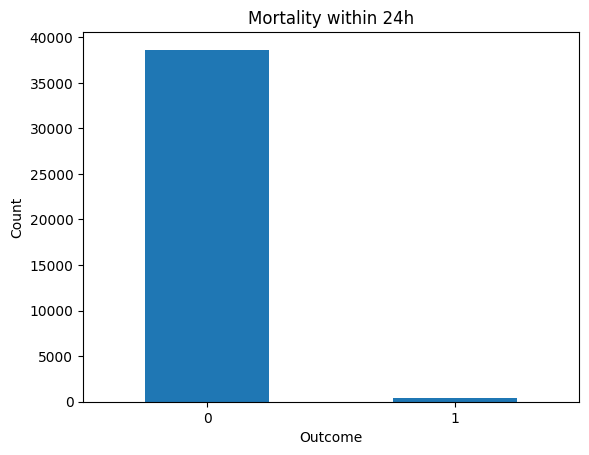

number of 0: 38633
number of 1: 421


In [310]:
import pandas as pd
import matplotlib.pyplot as plt

counts = combined_info['mortality_24h'].value_counts()

counts.plot(kind='bar')
plt.title('Mortality within 24h')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)
plt.show()

print("number of 0:", counts.get(0, 0))
print("number of 1:", counts.get(1, 0))

In [311]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
from imblearn.over_sampling import SMOTE


X_train = train_df[feature_columns].values
y_train = train_df[target_column].values

X_test = test_df[feature_columns].values
y_test = test_df[target_column].values










In [312]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make prediction on the testing data
y_pred = clf.predict(X_test)

# Classification Report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7350
           1       0.03      0.67      0.06         3

    accuracy                           0.99      7353
   macro avg       0.52      0.83      0.53      7353
weighted avg       1.00      0.99      1.00      7353



Using SMOTE

In [313]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

under = RandomUnderSampler(sampling_strategy=0.2, random_state=42)
over = SMOTE(random_state=42,  sampling_strategy=0.1)

pipeline = Pipeline(steps=[('o', over), ('u', under)])
# X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
X_train_oversampled, y_train_oversampled = pipeline.fit_resample(X_train, y_train)

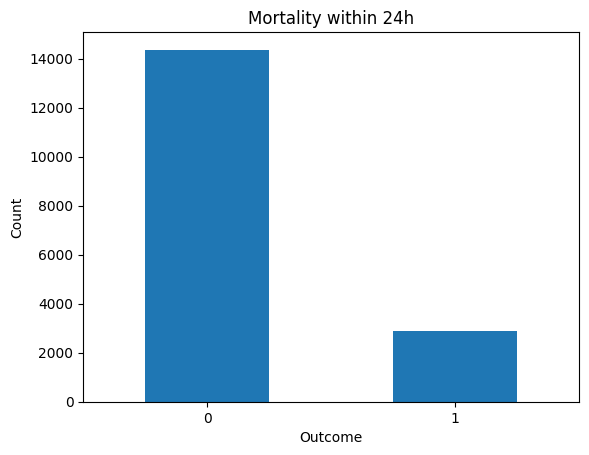

number of 0: 14360
number of 1: 2872


In [314]:
import pandas as pd
import matplotlib.pyplot as plt

oversampled_counts = pd.Series(y_train_oversampled).value_counts()

# Plotting the oversampled data
oversampled_counts.plot(kind='bar')
plt.title('Mortality within 24h')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['0', '1'], rotation=0)
plt.show()

# Printing the number of occurrences for each class
print(f"number of 0: {oversampled_counts.get(0, 0)}")
print(f"number of 1: {oversampled_counts.get(1, 0)}")


In [373]:
# Convert to PyTorch tensors

X_train_tensor = torch.tensor(X_train_oversampled[:, None, :], dtype=torch.float)
y_train_tensor = torch.tensor(y_train_oversampled[:, None], dtype=torch.float)
X_test_tensor = torch.tensor(X_test[:, None, :], dtype=torch.float)
y_test_tensor = torch.tensor(y_test[:, None], dtype=torch.float)

# Create TensorDatasets and DataLoaders
batch_size = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [374]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


In [375]:
# Parameters
seq_len = 24
input_size = X_train_oversampled.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 1

model = RNNModel(input_size, hidden_size, num_layers, num_classes)


criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)


In [376]:
num_epochs = 10

for epoch in range(num_epochs):
    for i, (sequences, labels) in enumerate(train_loader):
        outputs = model(sequences)
        outputs = outputs.squeeze()
        labels = labels.squeeze()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.6565
Epoch [2/10], Loss: 0.6098
Epoch [3/10], Loss: 0.5226
Epoch [4/10], Loss: 0.5019
Epoch [5/10], Loss: 0.4292
Epoch [6/10], Loss: 0.3277
Epoch [7/10], Loss: 0.3061
Epoch [8/10], Loss: 0.6440
Epoch [9/10], Loss: 0.1545
Epoch [10/10], Loss: 0.1897


In [377]:
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for sequences, labels in test_loader:
        outputs = model(sequences)
        probabilities = torch.sigmoid(outputs.squeeze())
        y_pred.extend(probabilities.cpu().numpy())
        y_true.extend(labels.cpu().numpy())



In [378]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

threshold = 0.5
y_pred_bin = (np.array(y_pred) > threshold).astype(int)

accuracy = accuracy_score(y_true, y_pred_bin)
precision = precision_score(y_true, y_pred_bin)
recall = recall_score(y_true, y_pred_bin)
f1 = f1_score(y_true, y_pred_bin)
roc_auc = roc_auc_score(y_true, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')


Accuracy: 0.9765
Precision: 0.2022
Recall: 0.5781
F1 Score: 0.2996
ROC AUC: 0.8807


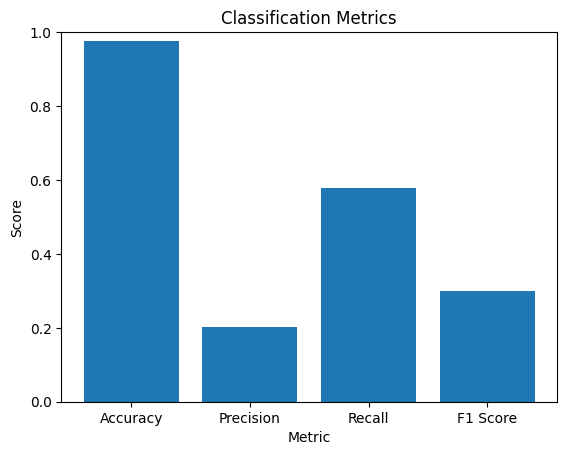

In [379]:
import matplotlib.pyplot as plt

# Assuming accuracy, precision, recall, and f1 are already calculated
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
names = list(metrics.keys())
values = list(metrics.values())

# Creating the bar plot
plt.bar(names, values)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim([0, 1])  # Assuming the metric values are between 0 and 1
plt.title('Classification Metrics')
plt.show()


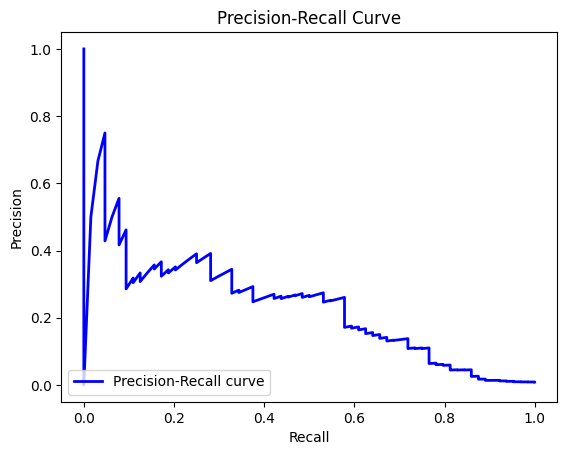

In [380]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Assuming y_pred contains the probabilities and y_true contains the true labels
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Plotting the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [381]:
def get_model_predictions_and_labels(model, data_loader):
    model.eval()
    predictions = []
    labels = []

    with torch.no_grad():
        for sequences, labels_batch in data_loader:
            outputs = model(sequences)
            probabilities = torch.sigmoid(outputs.squeeze()).cpu().numpy()
            predictions.extend(probabilities)
            labels.extend(labels_batch.cpu().numpy())

    return predictions, labels


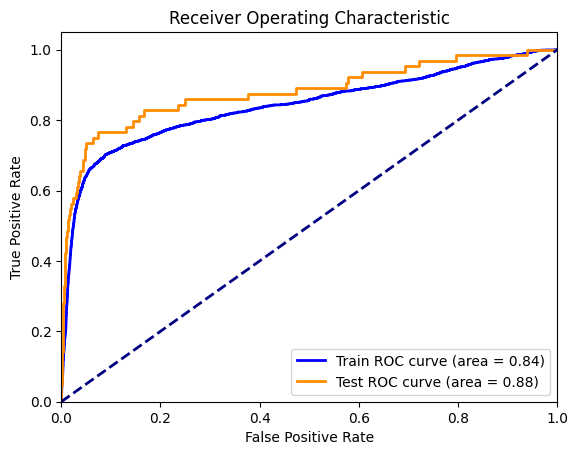

In [ ]:
y_pred_train, y_true_train = get_model_predictions_and_labels(model, train_loader)
y_pred_test, y_true_test = get_model_predictions_and_labels(model, test_loader)

from sklearn.metrics import roc_curve, auc

# Training set
fpr_train, tpr_train, _ = roc_curve(y_true_train, y_pred_train)
roc_auc_train = auc(fpr_train, tpr_train)

# Test set
fpr_test, tpr_test, _ = roc_curve(y_true_test, y_pred_test)
roc_auc_test = auc(fpr_test, tpr_test)

plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC curve (area = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC curve (area = {roc_auc_test:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


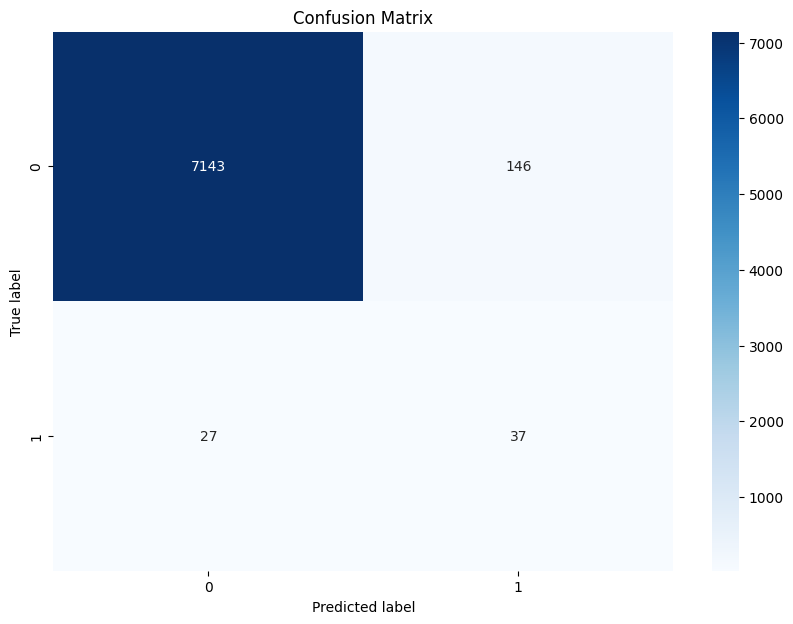

In [382]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_true are the true labels and y_pred_bin are the predicted labels after thresholding
cm = confusion_matrix(y_true, y_pred_bin)

# Plotting using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [383]:
# Assuming 'df' is your DataFrame

# Count the number of 1s in 'mortality_24h' using a boolean mask
ones_count = (combined_info['mortality_24h'] == 1).sum()

print(ones_count)


421
